# Mask R-CNN for Human Pose Estimation Demo on COCO Images

A brief introduction to using the pre-trained model for human pose estimation.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "mylogs")

## Set path to model and images
coco/<br>
├─test2017/<br>
├─train2017/<br>
├─val2017/<br>
├─annotations/<br>

In [5]:
# Local path to trained weights file
MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_humanpose.h5")
# MODEL_PATH = model.find_last()[1]

# Directory of images to run detection on
COCO_DIR = "D:/Eigene Dateien/Dokumente/coco"

## Configurations

Set inference parameters and load weights

In [7]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert MODEL_PATH != "", "Provide path to trained weights"
print("Loading weights from ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Loading weights from  C:\Users\LStue\Mask_RCNN_Humanpose\mask_rcnn_coco_humanpose.h5


## Dataset

In [8]:
# Load dataset
assert inference_config.NAME == "coco"
# Training dataset
#load person keypoints dataset
train_dataset_keypoints = coco.CocoDataset(task_type="person_keypoints")
train_dataset_keypoints.load_coco(COCO_DIR, "train")
train_dataset_keypoints.prepare() 

val_dataset_keypoints = coco.CocoDataset(task_type="person_keypoints")
val_dataset_keypoints.load_coco(COCO_DIR, "val")
val_dataset_keypoints.prepare() 

print("Train Keypoints Image Count: {}".format(len(train_dataset_keypoints.image_ids)))
print("Train Keypoints Class Count: {}".format(train_dataset_keypoints.num_classes))
for i, info in enumerate(train_dataset_keypoints.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
print("Val Keypoints Image Count: {}".format(len(val_dataset_keypoints.image_ids)))
print("Val Keypoints Class Count: {}".format(val_dataset_keypoints.num_classes))
for i, info in enumerate(val_dataset_keypoints.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=13.07s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
Train Keypoints Image Count: 64115
Train Keypoints Class Count: 2
  0. BG                                                
  1. person                                            
Val Keypoints Image Count: 2693
Val Keypoints Class Count: 2
  0. BG                                                
  1. person                                            


## Show ground truth annotations of a random Image

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  float64
image_meta               shape: (10,)                 min:    0.00000  max: 1462.00000  int32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   88.00000  max:  955.00000  int32
gt_mask                  shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool
gt_keypoint              shape: (2, 17, 3)            min:    0.00000  max:  936.00000  int32
keypoint_shape: (2, 17, 3)


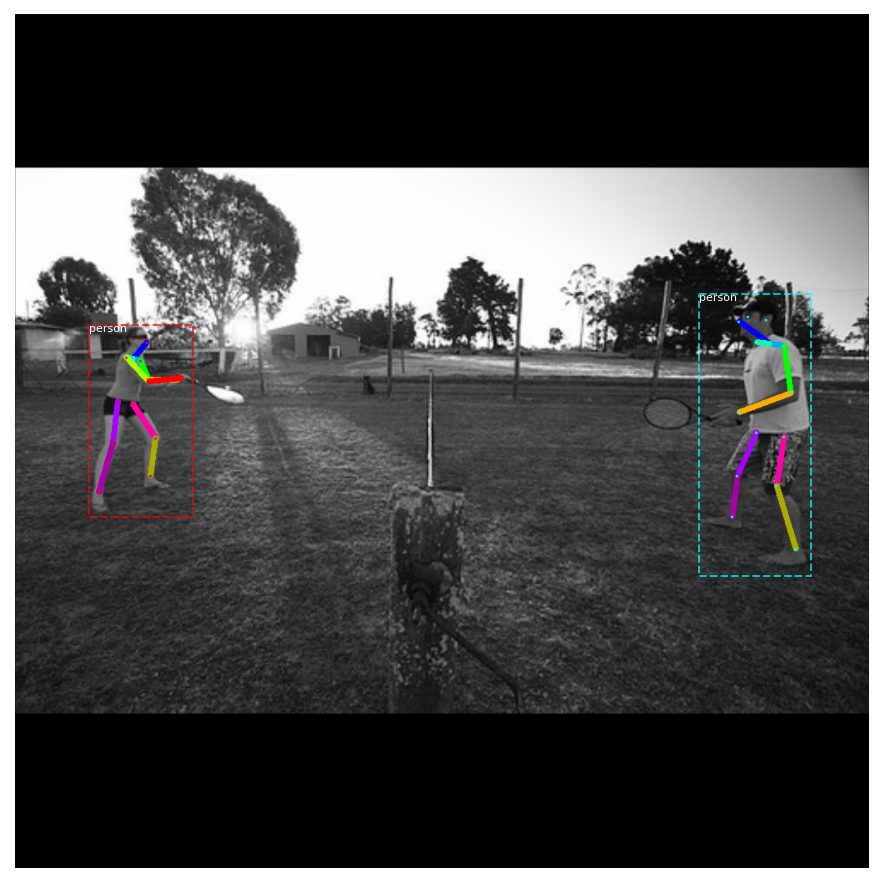

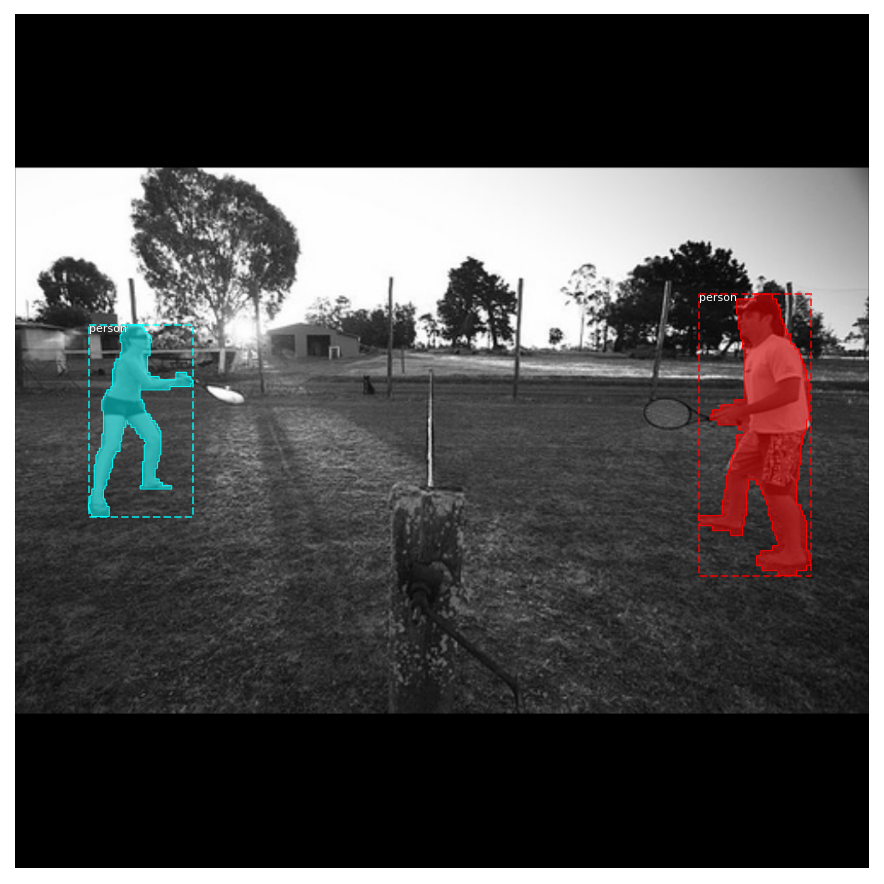

In [9]:
# Test on a random image
image_id = random.choice(val_dataset_keypoints.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint =\
    modellib.load_image_gt_keypoints(val_dataset_keypoints, inference_config, 
                           image_id, augment=False,use_mini_mask=inference_config.USE_MINI_MASK)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_keypoint", gt_keypoint)

# Show image and keypoints
visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,val_dataset_keypoints.class_names, skeleton = inference_config.LIMBS)

# Show image and masks
if(inference_config.USE_MINI_MASK):
    gt_mask = utils.expand_mask(gt_bbox,gt_mask,original_image.shape)
    
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            val_dataset_keypoints.class_names,)


## Inference
Run inference on image and show keypoints and instances

rois                     shape: (3, 4)                min:   93.00000  max:  953.00000  int32
keypoints                shape: (3, 17, 3)            min:    0.00000  max:  940.00000  int32
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
keypoints                shape: (3, 17, 3)            min:    0.00000  max:  940.00000  int32
masks                    shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
keypoint_shape: (3, 17, 3)


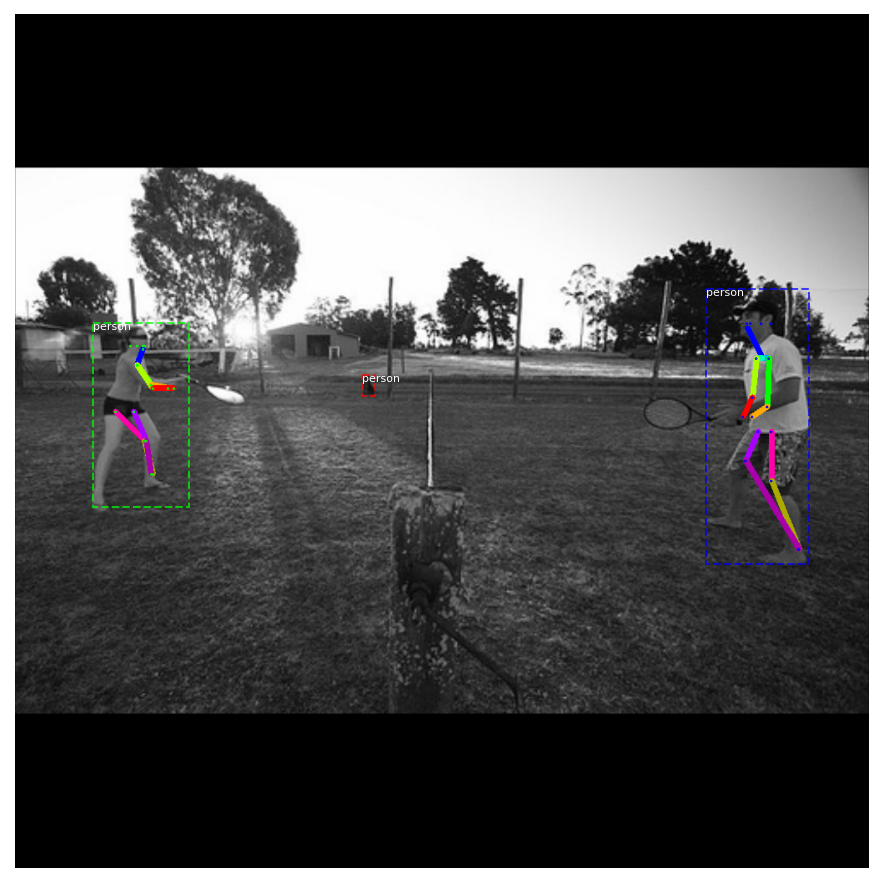

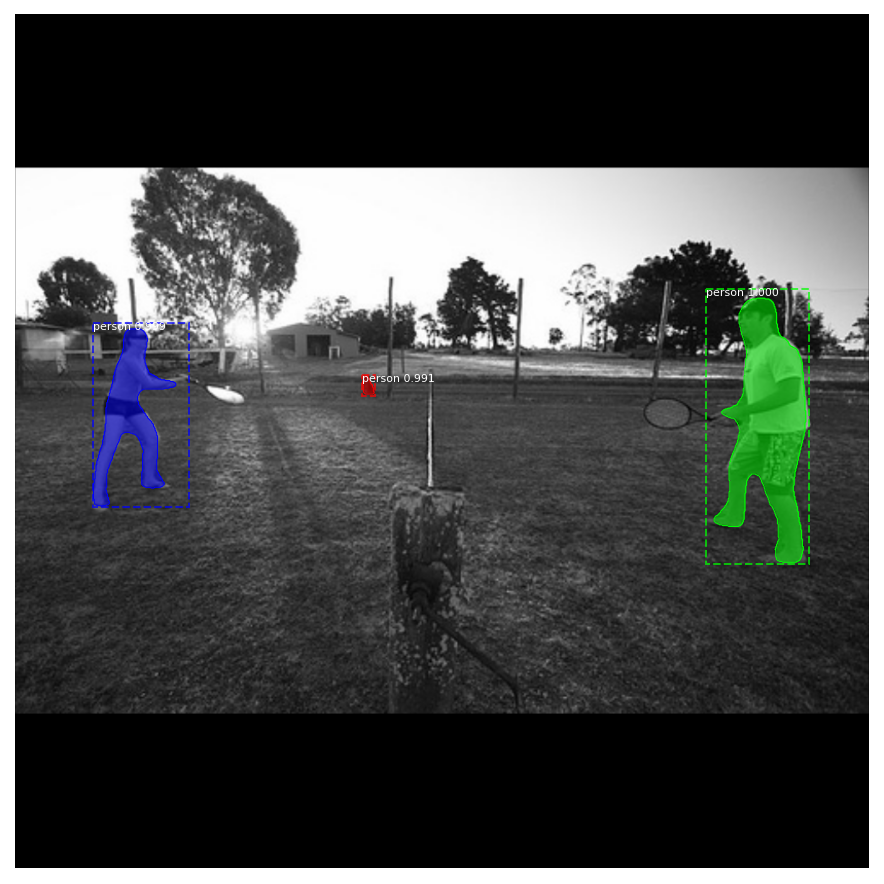

In [10]:
results = model.detect_keypoint([original_image], verbose=0)

r = results[0] # for one image

log("rois",r['rois'])
log("keypoints",r['keypoints'])
log("class_ids",r['class_ids'])
log("keypoints",r['keypoints'])
log("masks",r['masks'])

visualize.display_keypoints(original_image,r['rois'],r['keypoints'],r['class_ids'],val_dataset_keypoints.class_names, skeleton = inference_config.LIMBS)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_dataset_keypoints.class_names, r['scores'])